In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from scipy.optimize import fsolve

plt.rcParams.update({
    "text.usetex": True,                
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "figure.dpi": 150,                   
    "grid.alpha": 0.4,                    
})

# Quark Matter

EoS MIT Bag Model

$$
p = \frac{1}{3}(\epsilon - 4 B)
$$

In [57]:
# Quark matter

delta_e = np.geomspace(1e-30, 99, 5000) # delta_e = e - 1

list_p_quark = delta_e / 3.0 # p = 1/3 * (e - 1)  becomes  p = 1/3 * delta_e

list_e_quark = 1.0 + delta_e

#print maximums and minimums
print(f"Quark matter EOS: min energy density = {min(list_e_quark):.3e}, max energy density = {max(list_e_quark):.3e}")
print(f"Quark matter EOS: min pressure = {min(list_p_quark):.3e}, max pressure = {max(list_p_quark):.3e}")

Quark matter EOS: min energy density = 1.000e+00, max energy density = 1.000e+02
Quark matter EOS: min pressure = 3.333e-31, max pressure = 3.300e+01


Now with the complete code to add the quark masses later

In [19]:
def number_density(N_d, mu, mass):
    z = mass / mu
    factor = N_d * mu**3 / (6 * np.pi**2)
    if z == 0.0:
        return factor # MeV^3
    else:
        return factor * (1 - z**2)**(3/2) # dimension of mu_q^3


def pressure_f(N_c, mu_q, m_q):
    z_q = m_q / mu_q
    factor  = N_c * mu_q**4 / (24 * np.pi**2)
    
    if z_q == 0.0:
        return factor
    else: 
        term1 = (1-z_q**2)**(1/2)* (1-5/2 * z_q**2)
        term2 = 3/2 * z_q**4 * np.log( (1 + np.sqrt(1 - z_q**2)) / z_q )
        return factor * (term1 + term2) # dimension of mu_q^4

def energy_f(N_c, mu_q, m_q):
    z_q = m_q / mu_q
    factor  = N_c * mu_q**4 / (8 * np.pi**2)

    if z_q == 0.0:
        return factor
    else: 
        term1 = (1-z_q**2)**(1/2)* (1-1/2 * z_q**2)
        term2 = -1/2 * z_q**4 * np.log( (1 + np.sqrt(1 - z_q**2)) / z_q )
        return factor * (term1 + term2) # dimension of mu_q^4
    


$$

p' = \frac{p}{4B} \qquad \epsilon' = \frac{\epsilon}{4B}  \qquad \mu' = \frac{\mu}{(4B)^{1/4}} \qquad n' = \frac{n}{(4B)^{3/4}} \qquad M' = 2\sqrt{B} \frac{M}{M_p^3} \qquad R' = 2\sqrt{B} \frac{R}{M_p}
$$

In [20]:
#for massless quarks
m_u = 0.0 # MeV
m_d = 0.0 # MeV
m_s = 0.0 # MeV
m_e = 0.0  # MeV


In [21]:
# --- SISTEMA D'EQUACIONS A RESOLTRE ---

def equationsNB(vars, nB_target):
    mu_u, mu_e= vars
    
    # Beta equilibri
    mu_d = mu_u + mu_e
    mu_s = mu_d 
    
    # Densitats
    nu = number_density(6 ,mu_u, m_u)
    nd = number_density(6, mu_d, m_d)
    ns = number_density(6, mu_s, m_s)
    ne = number_density(2, mu_e, m_e)

    # 2/3 nu - 1/3 nd - 1/3 ns - ne = 0
    eq_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    # 1/3 (nu + nd + ns) = nB
    eq_baryon = (1/3)*(nu + nd + ns) - nB_target

    return [eq_charge, eq_baryon]
    

In [24]:
#Check for one nB


guess = [2, 2] # Scaled units

nB = 1e-3

sol = fsolve(equationsNB, guess, args=(nB))
mu_u, mu_e = sol    
mu_d = mu_u + mu_e
mu_s = mu_d
    
nu = number_density(6 ,mu_u, m_u)
nd = number_density(6, mu_d, m_d)
ns = number_density(6, mu_s, m_s)
ne = number_density(2, mu_e, m_e)

check_nb = (1/3)*(nu + nd + ns)
check_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

print(f"Check nB: {check_nb:.10f} (target: {nB:.10f})")
print(f"Check charge neutrality: {check_charge:.3e}(should be 0)")
print(f"Chemical potentials: mu_u={mu_u:.3f}, mu_d={mu_d:.3f}, mu_s={mu_s:.3f}, mu_e={mu_e:.3f}")

pressure_total = (pressure_f(6, mu_u, m_u) + pressure_f(6, mu_d, m_d) + pressure_f(6, mu_s, m_s) + pressure_f(2, mu_e, m_e)) - 1/4
energy_total =  (energy_f(6, mu_u, m_u) + energy_f(6, mu_d, m_d) + energy_f(6, mu_s, m_s) + energy_f(2, mu_e, m_e)) + 1/4

print(f"Pressure: {pressure_total:.3f}")
print(f"Energy density: {energy_total:.3f}")

Check nB: 0.0010000000 (target: 0.0010000000)
Check charge neutrality: -3.946e-17(should be 0)
Chemical potentials: mu_u=0.215, mu_d=0.215, mu_s=0.215, mu_e=0.000
Pressure: -0.250
Energy density: 0.250


If the baryonic density is too little, the pressure and energy of each fermion is numerically zero, and pressure and energy are essentially the vaccuum (Bag Constant). This happens for nb < 1e-2. This EoS also allows por negative pressures which are unphysical. Hence, it is necessary to find a value of ranges of baryon density where none of this two effect happens

In [39]:
def find_zero_pressure_density(nB_guess):
    def objective(nB_val):

        nb_scalar = nB_val[0] 
        
        sol = fsolve(equationsNB, [2, 2], args=(nb_scalar,))
        
        mu_u, mu_e = sol
        mu_d = mu_u + mu_e
        mu_s = mu_d 
        
        p_u = pressure_f(6, mu_u, m_u)
        p_d = pressure_f(6, mu_d, m_d)
        p_s = pressure_f(6, mu_s, m_s)
        p_e = pressure_f(2, mu_e, m_e)
        
        # B = 1/4 in your units
        pressure_total = (p_u + p_d + p_s + p_e) - 0.25
        return pressure_total

    # Solve for nB where pressure is 0
    optimal_nB = fsolve(objective, nB_guess)
    return optimal_nB[0]

nB_start = 1e-2 # Start slightly above your 1e-2 limit
optimal_nB = find_zero_pressure_density(nB_start)

print(f"The minimum physical baryon density (P=0) is: {optimal_nB:.15f}")

The minimum physical baryon density (P=0) is: 0.247505083095229


In [45]:
#Check for one nB


guess = [2, 2] # Scaled units

minimum_nb = optimal_nB + 1e-15

sol = fsolve(equationsNB, guess, args=(minimum_nb))
mu_u, mu_e = sol    
mu_d = mu_u + mu_e
mu_s = mu_d
    
nu = number_density(6 ,mu_u, m_u)
nd = number_density(6, mu_d, m_d)
ns = number_density(6, mu_s, m_s)
ne = number_density(2, mu_e, m_e)

check_nb = (1/3)*(nu + nd + ns)
check_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

print(f"Check nB: {check_nb:.10f} (target: {nB:.10f})")
print(f"Check charge neutrality: {check_charge:.3e}(should be 0)")
print(f"Chemical potentials: mu_u={mu_u:.3f}, mu_d={mu_d:.3f}, mu_s={mu_s:.3f}, mu_e={mu_e:.3f}")

pressure_total = (pressure_f(6, mu_u, m_u) + pressure_f(6, mu_d, m_d) + pressure_f(6, mu_s, m_s) + pressure_f(2, mu_e, m_e)) - 1/4
energy_total =  (energy_f(6, mu_u, m_u) + energy_f(6, mu_d, m_d) + energy_f(6, mu_s, m_s) + energy_f(2, mu_e, m_e)) + 1/4

print(f"Pressure: {pressure_total:.15f}")
print(f"Energy density: {energy_total:.3f}")

Check nB: 0.2475050831 (target: 0.2475050831)
Check charge neutrality: 3.886e-14(should be 0)
Chemical potentials: mu_u=1.347, mu_d=1.347, mu_s=1.347, mu_e=-0.000
Pressure: 0.000000000000001
Energy density: 1.000


Now the minimum pressure is 1e-15. Should be low enough.

Let's check the maximum values

In [61]:
guess = [2, 2] # Scaled units

maximum_nb = 1e1

sol = fsolve(equationsNB, guess, args=(maximum_nb))
mu_u, mu_e = sol    
mu_d = mu_u + mu_e
mu_s = mu_d
    
nu = number_density(6 ,mu_u, m_u)
nd = number_density(6, mu_d, m_d)
ns = number_density(6, mu_s, m_s)
ne = number_density(2, mu_e, m_e)

check_nb = (1/3)*(nu + nd + ns)
check_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

print(f"Check nB: {check_nb:.10f} (target: {nB:.10f})")
print(f"Check charge neutrality: {check_charge:.3e}(should be 0)")
print(f"Chemical potentials: mu_u={mu_u:.3f}, mu_d={mu_d:.3f}, mu_s={mu_s:.3f}, mu_e={mu_e:.3f}")

pressure_total = (pressure_f(6, mu_u, m_u) + pressure_f(6, mu_d, m_d) + pressure_f(6, mu_s, m_s) + pressure_f(2, mu_e, m_e)) - 1/4
energy_total =  (energy_f(6, mu_u, m_u) + energy_f(6, mu_d, m_d) + energy_f(6, mu_s, m_s) + energy_f(2, mu_e, m_e)) + 1/4

print(f"Pressure: {pressure_total:.15f}")
print(f"Energy density: {energy_total:.3f}")

Check nB: 10.0000000000 (target: 100.0000000000)
Check charge neutrality: -2.423e-11(should be 0)
Chemical potentials: mu_u=4.621, mu_d=4.621, mu_s=4.621, mu_e=0.000
Pressure: 34.409943081904402
Energy density: 104.230


In [73]:
list_nb = np.linspace(minimum_nb, maximum_nb, int(1e5))
list_failed_nb = []


grid_e_quark = []
grid_p_quark = []
guess = [2, 2]  # Initial guess for mu_u and mu_e

for nB in list_nb:
    sol = fsolve(equationsNB, guess, args=(nB))
    mu_u, mu_e = sol    
    mu_d = mu_u + mu_e
    mu_s = mu_d
    guess = [mu_u, mu_e]  # Update guess for next iteration

    #print(f"nB={nB:.3e} fm^-3 -> mu_u={mu_u:.3f}, mu_d={mu_d:.3f}, mu_s={mu_s:.3f}, mu_e={mu_e:.3f}")
    nu = number_density(6 ,mu_u, m_u)
    nd = number_density(6, mu_d, m_d)
    ns = number_density(6, mu_s, m_s)
    ne = number_density(2, mu_e, m_e)

    check_nb = (1/3)*(nu + nd + ns) - nB
    check_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    if abs(check_nb) > 1e-6:
        print(f"Warning: nB check failed: {check_nb:.3e}")

    if abs(check_charge) > 1e-6:
        print(f"Warning: charge neutrality check failed: {check_charge:.3e}")


    pressure_total = (pressure_f(6, mu_u, m_u) + pressure_f(6, mu_d, m_d) +
                    pressure_f(6, mu_s, m_s) + pressure_f(2, mu_e, m_e)) - 1/4
    
    if pressure_total < 0:
        print('Negative pressure reached, stopping at nB=', nB)
        list_failed_nb.append(nB)
        continue


    energy_total =  (energy_f(6, mu_u, m_u) + energy_f(6, mu_d, m_d) +
                    energy_f(6, mu_s, m_s) + energy_f(2, mu_e, m_e)) + 1/4


    grid_e_quark.append(energy_total) # MeV^4
    grid_p_quark.append(pressure_total) # MeV^4




list_nb_1 = list_nb[len(list_failed_nb):]
print("Number of points in EOS with positive pressure:", len(list_nb_1))
print("Failed points (negative pressure):", len(list_failed_nb))


Number of points in EOS with positive pressure: 100000
Failed points (negative pressure): 0


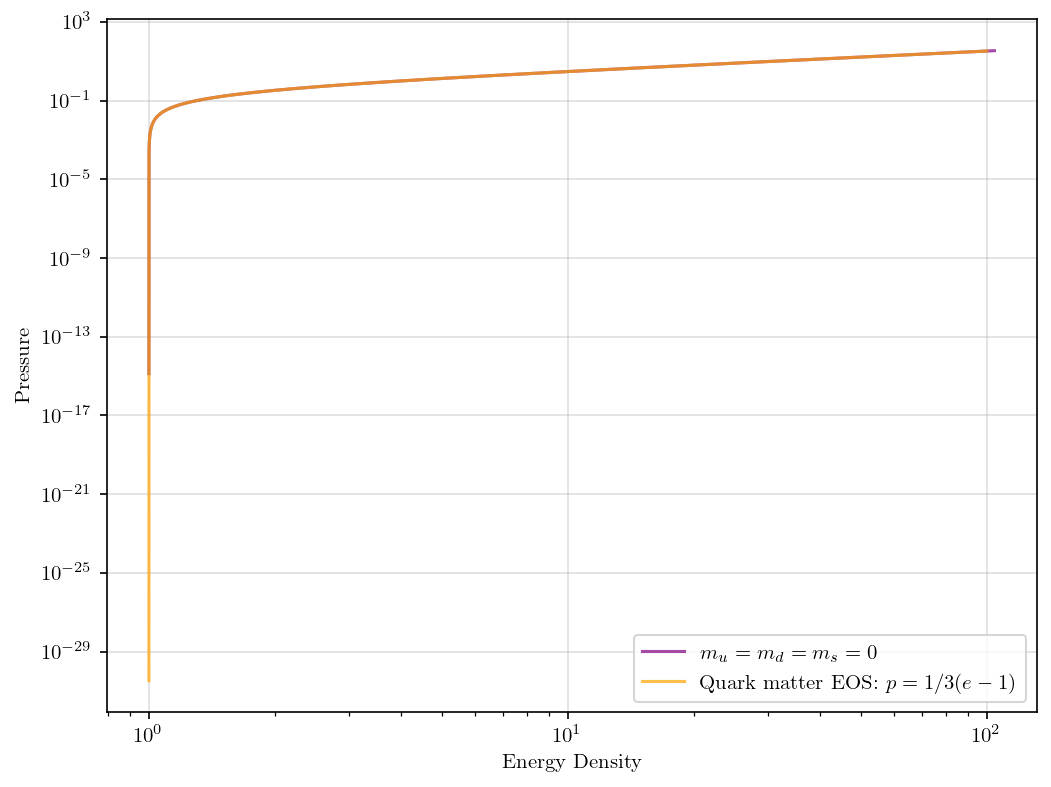

In [74]:
plt.figure(figsize=(8,6), dpi=150)

plt.plot(grid_e_quark, grid_p_quark, 
        label='$m_u = m_d = m_s=  0$', color='purple', alpha=0.7)

plt.plot(list_e_quark, list_p_quark, 
        label='Quark matter EOS: $p = 1/3 (e - 1)$', color='orange', alpha=0.7)

plt.xlabel('Energy Density')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Pressure')
plt.grid()
plt.legend()

It is clear that the EoS grid computed numerically (with massless quarks) matches the analytical expression

# Dark Matter

# Boson stars

Equation of state in dimensionless units
$$
\epsilon'' = {p''} ^{2/n} + \frac{n+2}{n-2}p''
$$

Before reescaling to the MIT, must recover MeV units:

$$
\varepsilon_0 = \lambda (n/2 +1) m_b ^n \qquad \varepsilon = \varepsilon_0  \varepsilon'' \qquad p = \varepsilon_0  p''
$$

$$
\varepsilon ' =\frac{\varepsilon_0  \varepsilon''}{4B}\qquad p ' =\frac{\varepsilon_0  p''}{4B}
$$



In [78]:
lamb = 1 #coupling strength
m_b = 1e3 # MeV
n = 4

epsilon_0 = lamb * ( n / 2 - 1) * m_b ** n  # MeV^4
B = 145 **4 # MeV^4


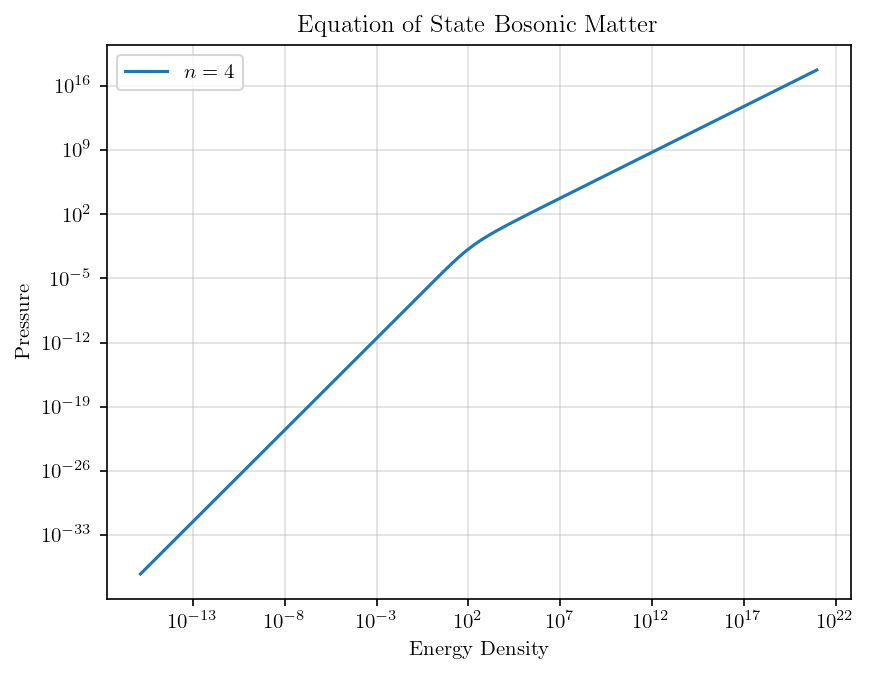

In [79]:
def energy_density(pressure, n):
    return pressure ** (2/n) + ((n + 2) / (n - 2)) * pressure


grid_p_DM = np.logspace(-40, 15, int(1e5)) * epsilon_0 / (4* B)
grid_e_DM = energy_density(grid_p_DM, 4) * epsilon_0 / (4* B)

#plot the eos
plt.plot(grid_e_DM, grid_p_DM,  label=f'$n={n}$')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Pressure')
plt.xlabel('Energy Density')
plt.title('Equation of State Bosonic Matter')


plt.legend()
plt.grid()
plt.show()

# Two fluids

In [83]:

# ----------------------------------------------------
# 1. ODE Definition 
# ----------------------------------------------------
def ode_TOV(r, x):
    p1, M1, p2, M2 = x
    
    p1_phys = max(0.0, p1)
    p2_phys = max(0.0, p2) # Treat negative pressure as 0 for physics

    if p1_phys > 0:
        e1 = np.interp(p1_phys, grid_p_quark, grid_e_quark)
    else:
        e1 = 0.0
        
    if p2_phys > 0:
        e2 = np.interp(p2_phys, grid_p_DM, grid_e_DM)
    else:
        e2 = 0.0
    
    M = M1 + M2

    if r < 1e-9:
        return [0.0, 4 * np.pi * r**2 * e1, 0.0, 4 * np.pi * r**2 * e2]

    term1_q = (e1 + p1_phys)
    term1_dm = (e2 + p2_phys)
    term2 = 1 + 4 * np.pi * r**3 * (p1_phys + p2_phys) / M
    term3 = 1 - 2 * M / r

    if term3 <= 1e-9: # negative or zero, horizon reached
        return [0, 0, 0, 0]

    factor = - (M / r**2) / term3

    # Fluid 1 (Quark)
    if p1 <= 0: # If raw pressure is negative, stop contribution
        dp1dr = 0.0
        dM1dr = 0.0 
    else:
        dp1dr = factor * term1_q * term2
        dM1dr = 4 * np.pi * r**2 * e1

    # Fluid 2 (Dark Matter)
    if p2 <= 0: # If raw pressure is negative, stop contribution
        dp2dr = 0.0
        dM2dr = 0.0
    else:
        dp2dr = factor * term1_dm * term2
        dM2dr = 4 * np.pi * r**2 * e2

    return [dp1dr, dM1dr, dp2dr, dM2dr]

# ----------------------------------------------------
# 2. Events 
# ----------------------------------------------------
def event_DM_surface(r, x):
    return x[2]
event_DM_surface.terminal = False 
event_DM_surface.direction = -1

def event_Quark_surface(r, x):
    return x[0]
event_Quark_surface.terminal = True
event_Quark_surface.direction = -1

# ----------------------------------------------------
# 3. Solve
# ----------------------------------------------------

#Initial conditions
hc = 197.3269804 # MeV fm
r0 = 1e-6
central_energy_quark = 1000 * hc**3 / (4 * B) #1000 mev /fm^3# i want this specific value
central_pressure_quark = np.interp(central_energy_quark, grid_e_quark, grid_p_quark)
central_mass_quark = (4/3) * np.pi * r0**3 * central_energy_quark

central_pressure_DM = 3e6 * hc**3 / (4 * B) #3e6 mev /fm^3# i want this specific value
central_energy_DM = np.interp(central_pressure_DM, grid_p_DM, grid_e_DM)
central_mass_DM = (4/3) * np.pi * r0**3 * central_energy_DM


print(f"Central pressure quark: {central_pressure_quark:.8e}")
print(f"Central energy quark:   {central_energy_quark:.8e}")
print(f"Central mass quark:     {central_mass_quark:.8e}")
print()
print(f"Central pressure DM: {central_pressure_DM:.8e}")
print(f"Central energy DM:   {central_energy_DM:.8e}")
print(f"Central mass DM:     {central_mass_DM:.8e}")

x0 = [central_pressure_quark, central_mass_quark, central_pressure_DM, central_mass_DM]

sol = solve_ivp(
    ode_TOV, 
    (r0, 1e12), 
    x0, 
    events=[event_DM_surface, event_Quark_surface],
    rtol=1e-8, 
    atol=1e-10,
    first_step=1e-7 
)

# ----------------------------------------------------
# 4. Solutions
# ----------------------------------------------------
r_adim = sol.t.copy()
p1_adim = sol.y[0].copy()
m1_adim = sol.y[1].copy()
p2_adim = sol.y[2].copy()
m2_adim = sol.y[3].copy()

# --- LAST POSITIVE PRESSURE ---

# For Quark Matter
idx_q_valid = np.where(p1_adim > 0)[0] # Indices where pressure is positive

if len(idx_q_valid) > 0: 

    last_q_idx = idx_q_valid[-1] # Last index with positive pressure
    
    p1_adim[last_q_idx+1:] = 0.0 # Force all next pressures to 0.0
    
    R_quark_final = r_adim[last_q_idx]  # Store the radius of the last positive point

    print(f"Quark Surface detected. Profile clamped at index {last_q_idx}, R={R_quark_final:.4e}")
else:
    R_quark_final = None
    print("Quark pressure never positive or immediately zero.")


# For Dark Matter 
idx_dm_valid = np.where(p2_adim > 0)[0]

if len(idx_dm_valid) > 0:

    last_dm_idx = idx_dm_valid[-1]
    
    p2_adim[last_dm_idx+1:] = 0.0
    
    R_DM_final = r_adim[last_dm_idx]
    
    print(f"DM Surface detected. Profile clamped at index {last_dm_idx}, R={R_DM_final:.4e}")
else:
    R_DM_final = None
    print("DM pressure never positive or immediately zero.")


# ----------------------------------------------------
# 5. Unit Conversions & Plotting
# ----------------------------------------------------
M_p = 1.2209e22  # MeV
mev_to_kg = 1.78266192e-30 
msun_kg = 1.98847e30

factor_R_to_km = (M_p / (2 * np.sqrt(B))) * hc * 1e-18
factor_M_to_Solar = (M_p **3 / (2 * np.sqrt(B))) * mev_to_kg / msun_kg
factor_P_to_MeV4 = 4 * B


R_km = r_adim * factor_R_to_km
P1_phys = p1_adim * factor_P_to_MeV4
M1_phys = m1_adim * factor_M_to_Solar
P2_phys = p2_adim * factor_P_to_MeV4
M2_phys = m2_adim * factor_M_to_Solar



Central pressure quark: 1.11512550e+00
Central energy quark:   4.34537649e+00
Central mass quark:     1.82018705e-17

Central pressure DM: 1.30361295e+04
Central energy DM:   2.21821676e+07
Central mass DM:     9.29164465e-11
Quark Surface detected. Profile clamped at index 221, R=1.9345e-01
DM Surface detected. Profile clamped at index 167, R=1.0845e-03


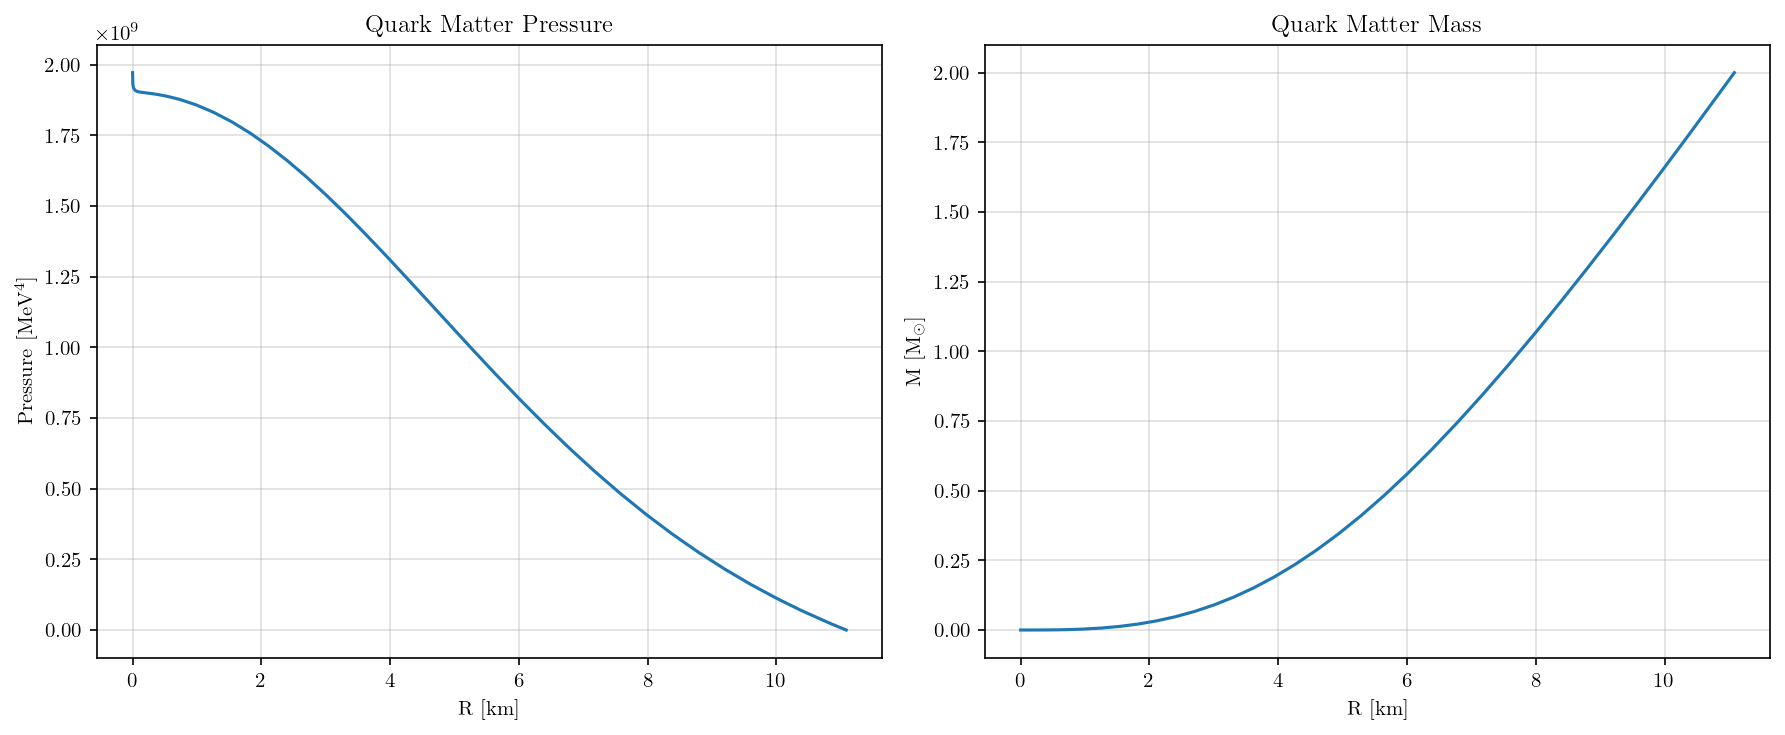

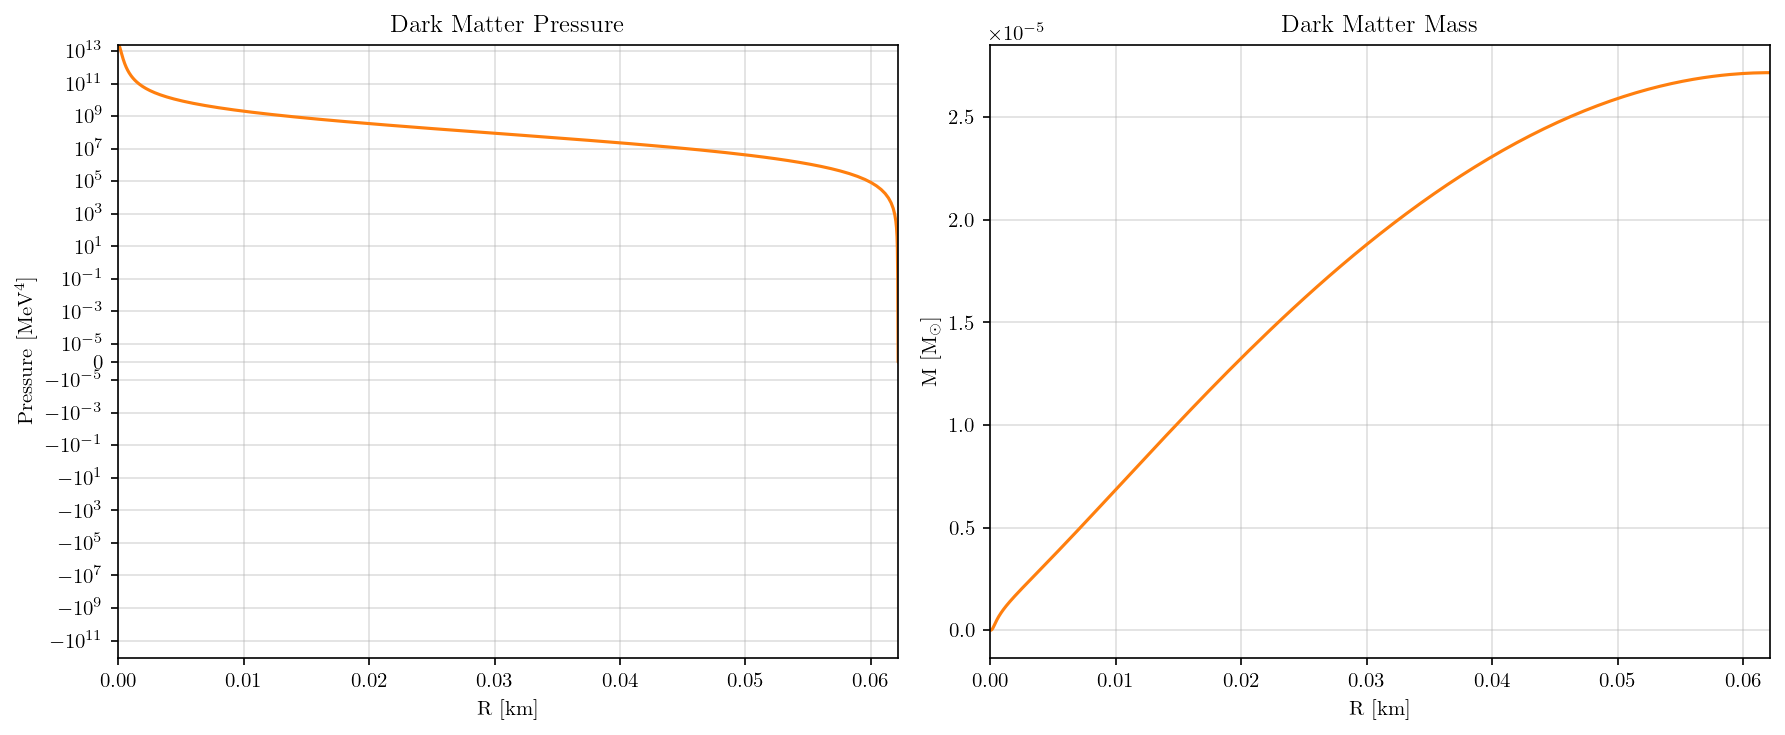

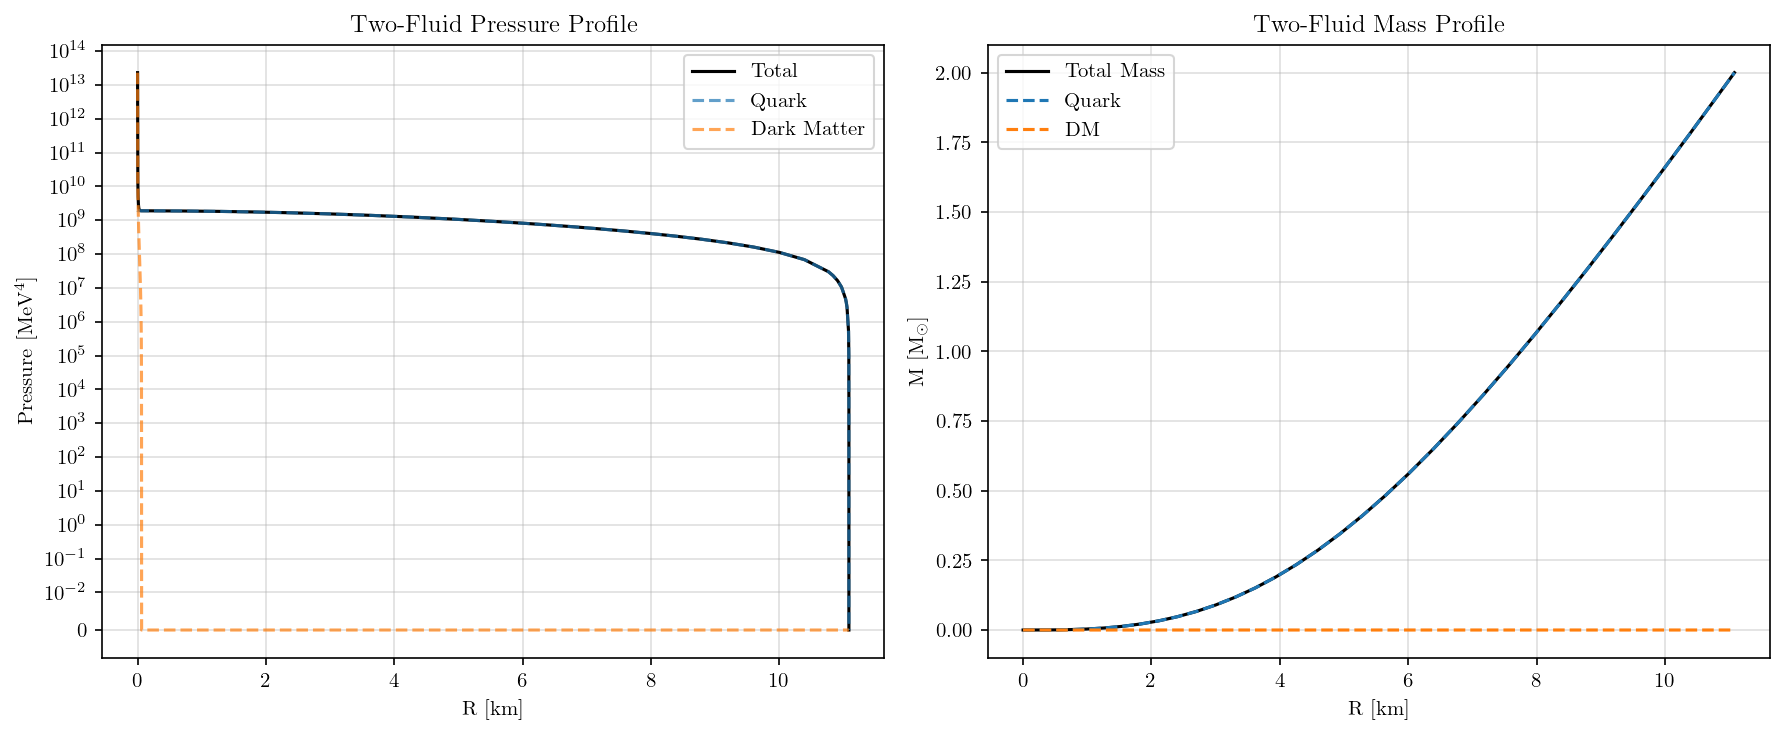

----- Final Results -----
Final Quark Radius: 11.0834 km
Final DM Radius:    0.0621 km
Total Mass:   2.0000 Solar Masses


In [84]:

# --- PLOTS ---

# --- PLOT 1: Quark Matter Only ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(R_km, P1_phys, color='tab:blue')
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.title("Quark Matter Pressure")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(R_km, M1_phys, color='tab:blue')
plt.xlabel("R [km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Quark Matter Mass")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PLOT 2: Dark Matter Only ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)

plt.plot(R_km, P2_phys, color='tab:orange')
plt.xlim(0, R_DM_final * factor_R_to_km)
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.yscale('symlog', linthresh=1e-5) 
plt.title("Dark Matter Pressure")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(R_km, M2_phys, color='tab:orange')
plt.xlim(0, R_DM_final * factor_R_to_km)
plt.xlabel("R [km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Dark Matter Mass")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PLOT 3: Two Fluids Combined ---
plt.figure(figsize=(12,5))

P_total = P1_phys + P2_phys
M_total = M1_phys + M2_phys

plt.subplot(1,2,1)
plt.plot(R_km, P_total, label='Total', color='black')
plt.plot(R_km, P1_phys, '--', label='Quark', color='tab:blue', alpha=0.7)
plt.plot(R_km, P2_phys, '--', label='Dark Matter', color='tab:orange', alpha=0.7)
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.title("Two-Fluid Pressure Profile")
plt.legend()
plt.grid(True)
plt.yscale('symlog', linthresh=1e-2)

plt.subplot(1,2,2)
plt.plot(R_km, M_total, label='Total Mass', color='black')
plt.plot(R_km, M1_phys, '--', label='Quark', color='tab:blue')
plt.plot(R_km, M2_phys, '--', label='DM', color='tab:orange')
plt.xlabel("R [km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Two-Fluid Mass Profile")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("----- Final Results -----")
print(f"Final Quark Radius: {R_quark_final * factor_R_to_km:.4f} km")
print(f"Final DM Radius:    {R_DM_final * factor_R_to_km:.4f} km")

# Print Final Physical Values
print(f"Total Mass:   {M_total[-1]:.4f} Solar Masses")